In [153]:
#Importing the neccesary library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

from xgboost import XGBRegressor
from scipy.stats import pareto

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_validate

from sklearn.preprocessing import StandardScaler

In [34]:
#Importing the data
data = pd.read_csv("medical_insurance.csv", sep=",")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Preprocessing

In [35]:
#First look
print("Missing values :")
print(data.isna().sum(axis=0))
print()
print("Data types")
print(data.dtypes)
print()
print(data.describe())
for var in data.select_dtypes(include="object").columns.to_list():
    print()
    print(data[var].value_counts())

Missing values :
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Data types
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

               age          bmi     children       charges
count  2772.000000  2772.000000  2772.000000   2772.000000
mean     39.109668    30.701349     1.101732  13261.369959
std      14.081459     6.129449     1.214806  12151.768945
min      18.000000    15.960000     0.000000   1121.873900
25%      26.000000    26.220000     0.000000   4687.797000
50%      39.000000    30.447500     1.000000   9333.014350
75%      51.000000    34.770000     2.000000  16577.779500
max      64.000000    53.130000     5.000000  63770.428010

sex
male      1406
female    1366
Name: count, dtype: int64

smoker
no     2208
yes     564
Name: count, dtype: int64

region
southeast    766
southwest    684
northwest    

In [36]:
#Encoding
#Since each categorical variable (3 of the six explaining variables) have only 2 (for sex and smoker) or 4 values (for region), we can do a one hot encoding.
#It will generate only 6 columns resulting in 9 columns used in total to predict the charges (we drop the 3 categorical variables and replace them with their dummies).
cat_var = data.select_dtypes("object").columns


encoder = OneHotEncoder(drop = "if_binary",sparse_output=False)
output = encoder.fit_transform(data[cat_var])
df_output = pd.DataFrame(output, columns=["sex_male","smoker_yes","region_northeast","region_northwest","region_southeast","region_southwest"])
df_output.shape 
# print(data.head())
# print(df_output.head())

data_processed = data.copy()
data_processed.drop(["sex","smoker","region"], axis=1, inplace=True)
data_processed[["sex_male","smoker_yes","region_northeast","region_northwest","region_southeast","region_southwest"]] = df_output
data_processed[["sex_male","smoker_yes","region_northeast","region_northwest","region_southeast","region_southwest"]] = data_processed[["sex_male","smoker_yes","region_northeast","region_northwest","region_southeast","region_southwest"]].astype(int)
data_processed.head()


,age,bmi,children,charges,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,0,1
1,18,33.770,1,1725.55230,1,0,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,0,1,0
3,33,22.705,0,21984.47061,1,0,0,1,0,0
4,32,28.880,0,3866.85520,1,0,0,1,0,0


In [37]:
#Adding a constant columns 
data_processed["const"] = pd.Series(np.ones(shape=(2772,)))
cols = ['const'] + [col for col in data_processed.columns if col != 'const']
data_processed = data_processed[cols]
data_processed.head()

,const,age,bmi,children,charges,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,1.0,19,27.900,0,16884.92400,0,1,0,0,0,1
1,1.0,18,33.770,1,1725.55230,1,0,0,0,1,0
2,1.0,28,33.000,3,4449.46200,1,0,0,0,1,0
3,1.0,33,22.705,0,21984.47061,1,0,0,1,0,0
4,1.0,32,28.880,0,3866.85520,1,0,0,1,0,0


# Analyse descriptive

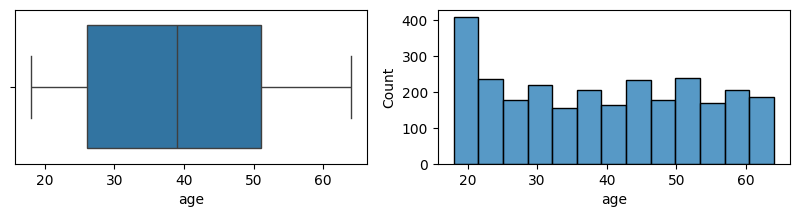

count    2772.000000
mean       39.109668
std        14.081459
min        18.000000
25%        26.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64


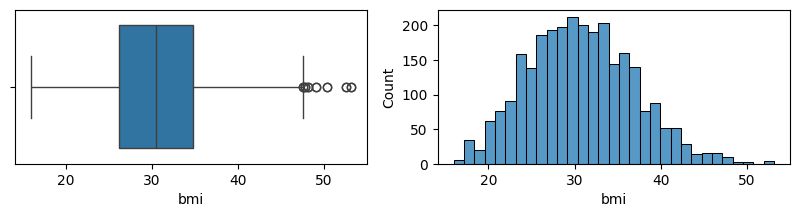

count    2772.000000
mean       30.701349
std         6.129449
min        15.960000
25%        26.220000
50%        30.447500
75%        34.770000
max        53.130000
Name: bmi, dtype: float64


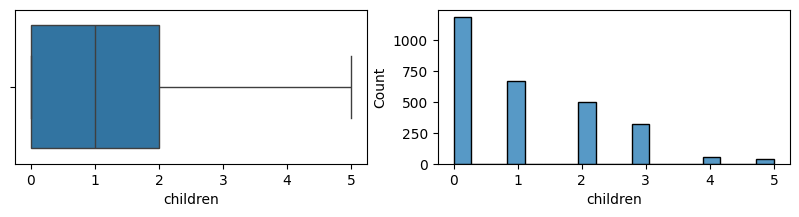

count    2772.000000
mean        1.101732
std         1.214806
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: children, dtype: float64


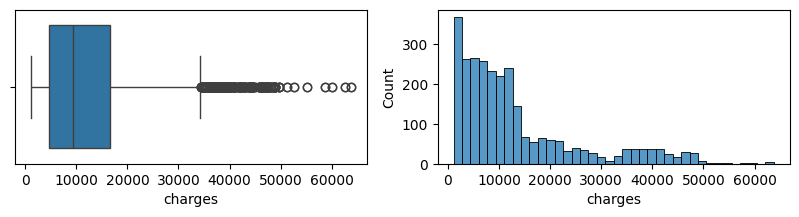

count     2772.000000
mean     13261.369959
std      12151.768945
min       1121.873900
25%       4687.797000
50%       9333.014350
75%      16577.779500
max      63770.428010
Name: charges, dtype: float64


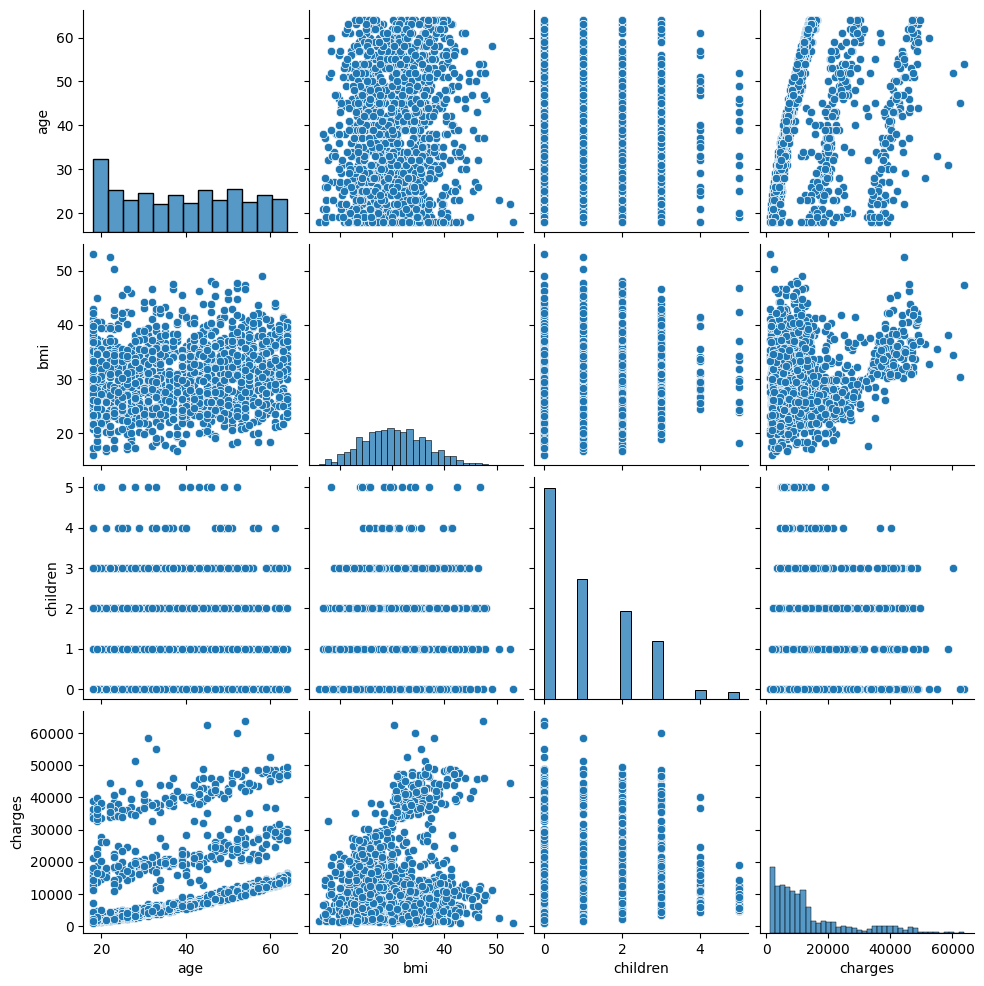

In [38]:
#Visualisation
for var in data.select_dtypes("number").columns:
    fig, axs = plt.subplots(1,2,figsize=(10,2))
    sns.boxplot(data, x = var, whis = 1.5, ax = axs[0])
    sns.histplot(data,x=var, ax = axs[1])
    plt.show()
    print(data[var].describe())

sns.pairplot(data)
plt.show()

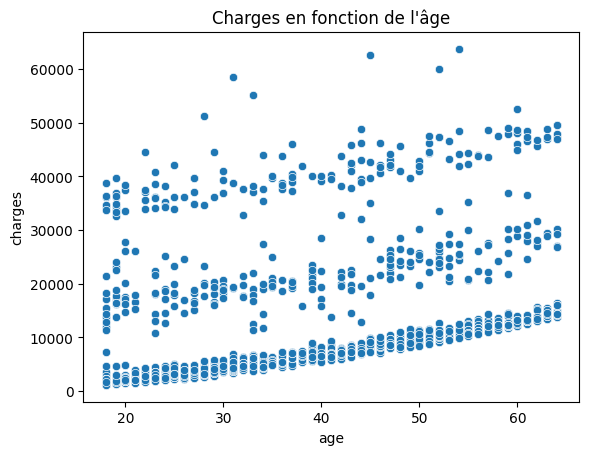

In [39]:
sns.scatterplot(data = data, y = "charges",x = "age")
plt.title("Charges en fonction de l'âge")
plt.show()

On observe très clairement trois "traces" de points avec des charges clairement distinctes pour manifestement trois groupes d'individus.

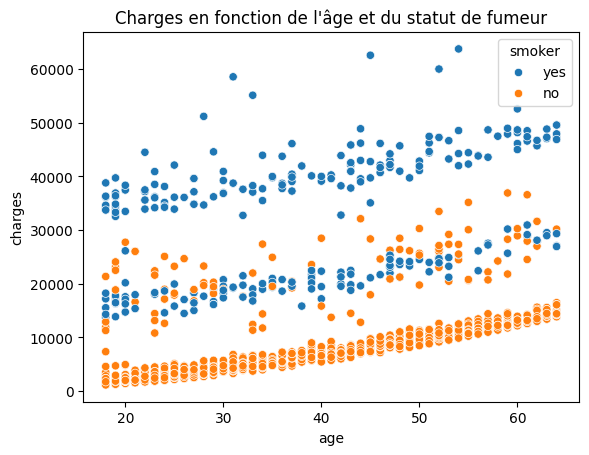

In [40]:
sns.scatterplot(data = data, y = "charges",x = "age",hue="smoker")
plt.title("Charges en fonction de l'âge et du statut de fumeur")
plt.show()

Après plusieurs essais de coloration avec les variables catégorielles, on voit que le fait d'être fumeur influence clairement les charges de santé. \
Pour les "étages" 1 et 3, le phénomène est manifeste : être fumeur augmente les charges de santé (qui augmentent de toute façon avec l'âge).\
Cependant, pour l'étage 2, cela semble plus mitigé. Il faut donc explorer plus pour déterminer cet autre facteur.

In [41]:
import plotly.express as px

df = data.copy()

fig = px.scatter_3d(
    df,
    x="age",
    y="bmi",
    z="charges",
    color="smoker",          # coloration par catégorie
    symbol="smoker",         # symboles différents
    opacity=1,
    title="Charges en fonction de l'âge, du BMI et du statut de fumeur",
    size="charges",
    color_continuous_scale='Viridis'
)

fig.update_traces(marker=dict(size=4))
fig.show()

Pour le groupe intermédiaire, il semble y avoir une relation entre BMI et les charges. Plus il est élevé, les charges semblent l'être mais c'est à inspecter.\
Nous allons maintenant examiner les charges en fonction du BMI.

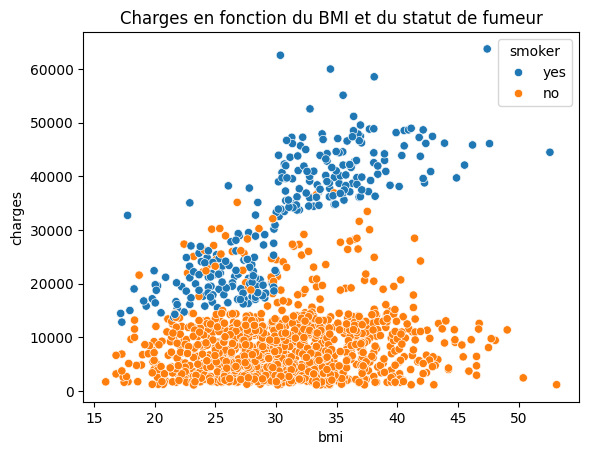

In [42]:
sns.scatterplot(data = data, y = "charges",x = "bmi",hue="smoker")
plt.title("Charges en fonction du BMI et du statut de fumeur")
plt.show()

On peut très clairement voir que pour les fumeurs, les charges de santé augmente assez peu avec le BMI et reste à peu près constante mais que pour les fumeurs, \
plus le BMI est important, plus les charges de santé le seront. Cela peut indiquer un facteur de risque supplémentaire. 

In [43]:
#Relation entre les variables catégorielles
nom_var = ["sex","smoker","region"]
seuil_corr_nom = 0
for i,var in enumerate(nom_var):
    ct_tab = []
    cr_tab = []
    for j in range(i+1,len(nom_var)):
        #print("i :", i, " j :", j)
        ct_tab.append(pd.crosstab(index=data[nom_var[i]], columns=data[nom_var[j]]))
        cr_tab.append(stats.contingency.association(ct_tab[j-1-i],correction=False,method="cramer"))
        if(cr_tab[j-i-1] >= seuil_corr_nom):
            print("Coefficient de Cramér de", nom_var[i], "et", nom_var[j]," : ", cr_tab[j-i-1])


Coefficient de Cramér de sex et smoker  :  0.08232647745208163
Coefficient de Cramér de sex et region  :  0.024768087180991518
Coefficient de Cramér de smoker et region  :  0.07906136988750963


On observe pas de corrélations claires entre ces variables.

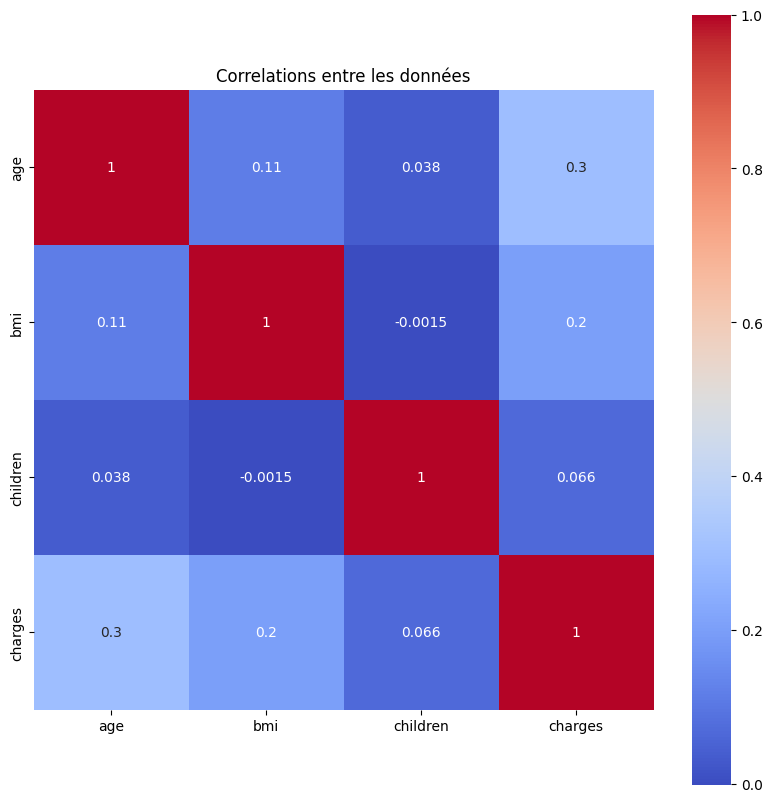

In [44]:
#Corrélations linéaires entre les variables numériques
X = data.select_dtypes("number")
X_corr = X.corr()
plt.figure(figsize=(10,10))
sns.heatmap(X_corr, annot=True,cmap = 'coolwarm', square=True)
plt.title('Correlations entre les données')
plt.show()

# from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel, pairwise_kernels, sigmoid_kernel
# X_corr_rbf1 = pairwise_kernels(X,metric="linear")
# print(pd.DataFrame(X_corr_rbf1).corr())

# plt.figure(figsize=(10,10))
# sns.heatmap(X_corr, annot=True,cmap = 'coolwarm', square=True)
# plt.title('Correlations entre les données')
# plt.show()

Il en est de même pour les variables numériques : la heatmap ne montre pas de corrélation linéaire supérieure à 0.3 (charges et age).

Faire beaucoup d'analyse descriptive 


# Model implementation

## Linear Model

In [45]:
#First LinearRegression => full model
y = data_processed["charges"]
X = data_processed.drop("charges", axis=1)

X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

age_mean = X_train["age"].mean()
age_std = X_train["age"].std()
bmi_mean = X_train["bmi"].mean()
bmi_std = X_train["bmi"].std()
children_mean = X_train["children"].mean()
children_std = X_train["children"].std()

X_train_std = X_train.copy()
X_train_std["age"] = (X_train["age"]-age_mean)/age_std
X_train_std["bmi"] = (X_train["bmi"]-bmi_mean)/bmi_std
X_train_std["children"] = (X_train["children"]-children_std)/children_std

X_test_std = X_test.copy()
X_test_std["age"] = (X_test["age"]-age_mean)/age_std
X_test_std["bmi"] = (X_test["bmi"]-bmi_mean)/bmi_std
X_test_std["children"] = (X_test["children"]-children_std)/children_std

results = sm.OLS(y_train,X_train_std).fit()
print(results.summary())

y_pred = results.predict(X_test_std)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(len(y_test)-1)/(len(y_test)-9-1) #On a 9 variables explicatives

print("RMSE :", rmse)
print("R2 :", r2)
print("Adjusted R² :", adj_r2)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     844.2
Date:                Mon, 01 Dec 2025   Prob (F-statistic):               0.00
Time:                        09:50:31   Log-Likelihood:                -22432.
No. Observations:                2217   AIC:                         4.488e+04
Df Residuals:                    2208   BIC:                         4.493e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             6781.2091    153.533  

On peut d'emblée voir que la variable sex (sex_male) n'est pas significative car sa p-value est de 0.8 soit bien plus que 0.05. \
On va vérifier les moyennes de charges pour chaque sex mais on ne la gardera pas dans les autres modèles. \
Autrement, on a déjà un bon modèle si l'on regarde le R² et sa variante ajustée : autour de 0.74 avec une statistique de Fisher très correcte. \
Cependant, l'AIC et le BIC sont assez élevé, on va essayer ensuite de corriger cela.

In [46]:
#Vérification numérique de l'influence de sex
moy_charges_male = data_processed[data_processed["sex_male"]==1]["charges"].mean()
moy_charges_female = data_processed[data_processed["sex_male"]==0]["charges"].mean()
print("Moyenne des charges pour les hommes :", moy_charges_male)
print("Moyenne des charges pour les femmes :",moy_charges_female)

med_charges_male = data_processed[data_processed["sex_male"]==1]["charges"].median()
med_charges_female = data_processed[data_processed["sex_male"]==0]["charges"].median()
print("Médiane des charges pour les hommes :",med_charges_male)
print("Médiane des charges pour les femmes :",med_charges_female)

Moyenne des charges pour les hommes : 14013.872721266001
Moyenne des charges pour les femmes : 12486.83197685066
Médiane des charges pour les hommes : 9361.3268
Médiane des charges pour les femmes : 9283.562


La variable "sex" ne semble donc effectivement pas avoir d'effet sur les charges médicales.

In [47]:
#Stepwise model selection : forward
y = data_processed["charges"]

col = data_processed.columns
col = col.drop("charges")
list_col = ["const"]
resumecustom = [[],[],[],[]]
for i,var in enumerate(col):
    if(var == "sex_male"):
        continue 
    if(i != 0):
        list_col.append(var) 
        
    # print("\nVariables used :")
    # print(list_col)
    X = data_processed[list_col]

    X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

    results = sm.OLS(y_train,X_train).fit()
    # list_col_string = "const,"
    # for i in range(len(list_col)):
    #     list_col_string = list_col_string + list_col[i]+ ","

    resumecustom[0].append(list_col[-1])
    resumecustom[1].append(results.rsquared)
    resumecustom[2].append(results.f_pvalue)
    resumecustom[3].append(results.aic)

    print(results.summary())

df_results = pd.DataFrame(np.transpose(resumecustom), columns=["Column added","R2","F-stat","AIC"])
df_results.head(10)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 01 Dec 2025   Prob (F-statistic):                nan
Time:                        09:50:32   Log-Likelihood:                -23985.
No. Observations:                2217   AIC:                         4.797e+04
Df Residuals:                    2216   BIC:                         4.798e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.337e+04    256.753     52.078      0.0

,Column added,R2,F-stat,AIC
0,const,3.3306690738754696e-16,nan,47972.47529546012
1,age,0.08027686460936756,3.34921898654967e-42,47788.95098451045
2,bmi,0.10592076211931911,1.490194520644532e-54,47728.25803611689
3,children,0.1091731416993943,3.4794943979037125e-55,47722.17858193749
4,smoker_yes,0.7521604593868949,0.0,44887.81847867935
5,region_northeast,0.7530679849149383,0.0,44881.68548748825
6,region_northwest,0.7535995533750951,0.0,44878.90782607847
7,region_southeast,0.7536063178697243,0.0,44880.846961373645
8,region_southwest,0.7536063178697243,0.0,44880.846961373645


On peut clairement voir que le R2 bondit après l'ajout de la variable smoker au modèle et que bmi, âge, children et sex n'ont que très peu d'influence (comme prévu pour sex). \
Les statistiques de Fischer des modèles sont toutes proches de 0, indiquant que nous pouvons rejeter l'hypothèse nulle du Test de Fisher à savoir, tous les coefficients sont nuls.\
Nous allons essayer un modèle avec seulement age, bmi, et smoker afin de coller aux visualisations faites précédemment.

In [48]:
y = data_processed["charges"]
X = data_processed.drop("charges", axis=1)
X = X[["const","age","bmi","smoker_yes"]]

X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

results = sm.OLS(y_train,X_train).fit()
print(results.summary())

p = len(X_test.columns)-1
n = len(y_test)
y_pred = results.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(n-1)/(n-p-1) #On a p variables explicatives

print("RMSE :", rmse)
print("R2 :", r2)
print("Adjusted R² :", adj_r2)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     2214.
Date:                Mon, 01 Dec 2025   Prob (F-statistic):               0.00
Time:                        09:50:32   Log-Likelihood:                -22448.
No. Observations:                2217   AIC:                         4.490e+04
Df Residuals:                    2213   BIC:                         4.493e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.115e+04    723.310    -15.415      0.0

On observe bien que le modèle possède un bon R² de 0.7345 et un R² ajusté de 0.733 après avoir prédit sur des données tests. Ces scores restent cohérents avec les résultats du train (0.75 pour les deux).\
De plus, toutes les composantes sont significatives (leur p-valeur est nulle).

Ecart-types des coefficients :
const         410.907926
age             9.653970
smoker_yes    330.560165
dtype: float64


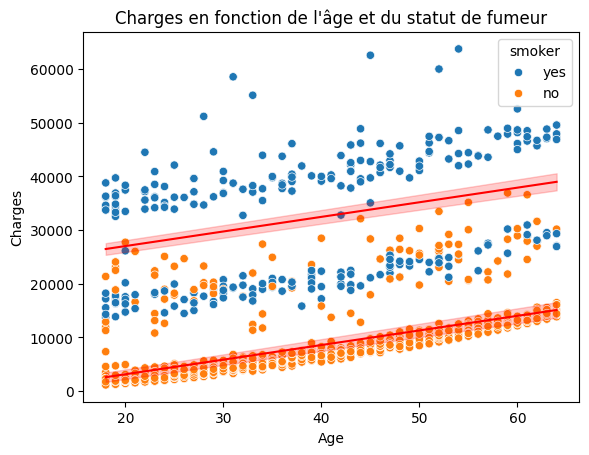

In [49]:
y = data_processed["charges"]
X = data_processed.drop("charges", axis=1)
X = X[["const","age","smoker_yes"]]
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)
results = sm.OLS(y_train,X_train).fit()
#Pas de scaler car une seule variable quantitative
print("Ecart-types des coefficients :")
print(results.bse)

age_range = np.linspace(data_processed['age'].min(), data_processed['age'].max(), 200)
charges_pred_non_fumeur = results.params.iloc[0] + results.params.iloc[1]*age_range + results.params.iloc[2]*0
charges_pred_fumeur = results.params.iloc[0] + results.params.iloc[1]*age_range + results.params.iloc[2]*1

se_pred_fumeur = np.sqrt(results.bse.iloc[0]**2 + (age_range*results.bse.iloc[1])**2 + (1*results.bse.iloc[2])**2)
se_pred_non_fumeur = np.sqrt(results.bse.iloc[0]**2 + (age_range*results.bse.iloc[1])**2 + (0*results.bse.iloc[2])**2)

lower_fumeur = charges_pred_fumeur - 1.96*se_pred_fumeur
upper_fumeur = charges_pred_fumeur + 1.96*se_pred_fumeur

lower_non_fumeur = charges_pred_non_fumeur - 1.96*se_pred_non_fumeur
upper_non_fumeur = charges_pred_non_fumeur + 1.96*se_pred_non_fumeur

sns.scatterplot(data = data, y = "charges",x = "age",hue="smoker")
plt.title("Charges en fonction de l'âge et du statut de fumeur")
plt.plot(age_range, charges_pred_non_fumeur, color='red', label='Droite de régression sans fumeur')
plt.plot(age_range, charges_pred_fumeur, color='red', label='Droite de régression avec fumeur')
plt.fill_between(age_range, lower_fumeur, upper_fumeur, color='red', alpha=0.2, label='IC 95%')
plt.fill_between(age_range, lower_non_fumeur, upper_non_fumeur, color='red', alpha=0.2, label='IC 95%')

plt.xlabel("Age")
plt.ylabel("Charges")
plt.show()

On peut maintenant essayer de prédire les charges à partir du BMI. D'après le graphe fait précédement, le coefficient semble cette fois différent selon l'état fumeur ou non.\
On va donc entraîner deux modèles de régression linéaire sur ces deux populations.

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     7.763
Date:                Mon, 01 Dec 2025   Prob (F-statistic):            0.00539
Time:                        18:22:32   Log-Likelihood:                -17887.
No. Observations:                1766   AIC:                         3.578e+04
Df Residuals:                    1764   BIC:                         3.579e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6474.6295    745.367      8.687      0.0

[]

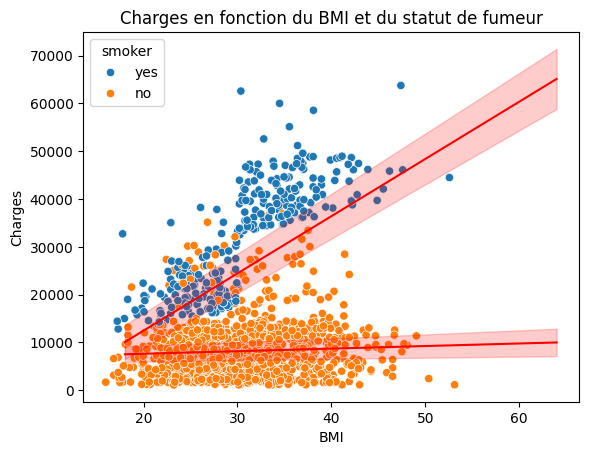

In [109]:
data_processed_fumeur = data_processed[data_processed["smoker_yes"]==1].reset_index()
data_processed_non_fumeur  = data_processed[data_processed["smoker_yes"]==0].reset_index()

#Pas de scaler car une seule variable quantitative

y_fumeur = data_processed_fumeur["charges"]
X_fumeur = data_processed_fumeur.drop("charges", axis=1)

#Modèle pour les non fumeurs
y_non_fumeur = data_processed_non_fumeur["charges"]
X_non_fumeur = data_processed_non_fumeur.drop("charges", axis=1)
X_non_fumeur = X_non_fumeur[["const","bmi"]]

X_train_non_fumeur, X_test_non_fumeur, y_train_non_fumeur,y_test_non_fumeur = train_test_split(X_non_fumeur,y_non_fumeur, test_size=0.2, random_state=42)

results_non_fumeur = sm.OLS(y_train_non_fumeur,X_train_non_fumeur).fit()


#Modèle pour les fumeurs
y_fumeur = data_processed_fumeur["charges"]
X_fumeur = data_processed_fumeur.drop("charges", axis=1)
X_fumeur = X_fumeur[["const","bmi"]]

X_train_fumeur, X_test_fumeur, y_train_fumeur,y_test_fumeur = train_test_split(X_fumeur,y_fumeur, test_size=0.2, random_state=42)

results_fumeur = sm.OLS(y_train_fumeur,X_train_fumeur).fit()

#Résultats et analyses
print(results_non_fumeur.summary())
print(results_fumeur.summary())

print()
## Fumeur
p_fumeur = len(X_test_fumeur.columns)-1
n_fumeur = len(y_test_fumeur) 

y_pred_fumeur = results_fumeur.predict(X_test_fumeur)
rmse_fumeur = root_mean_squared_error(y_test_fumeur, y_pred_fumeur)
r2_fumeur = r2_score(y_test_fumeur, y_pred_fumeur)
adj_r2_fumeur = 1-(1-r2)*(n_fumeur-1)/(n_fumeur-p_fumeur-1) #On a p variables explicatives

print("RMSE (fumeur) :", rmse_fumeur)
print("R2 (fumeur) :", r2_fumeur)
print("Adjusted R² (fumeur) :", adj_r2_fumeur)

## Non fumeur
p_non_fumeur = len(X_test_non_fumeur.columns)-1
n_non_fumeur = len(y_test_non_fumeur) 

y_pred_non_fumeur = results_non_fumeur.predict(X_test_non_fumeur)
rmse_non_fumeur = root_mean_squared_error(y_test_non_fumeur, y_pred_non_fumeur)
r2_non_fumeur = r2_score(y_test_non_fumeur, y_pred_non_fumeur)
adj_r2_non_fumeur = 1-(1-r2_non_fumeur)*(n_non_fumeur-1)/(n_non_fumeur-p_non_fumeur-1) #On a p variables explicatives

print("RMSE (non fumeur) :", rmse_non_fumeur)
print("R2 (non fumeur) :", r2_non_fumeur)
print("Adjusted R² (non fumeur) :", adj_r2_non_fumeur)


#Graphique avec droites de régression
bmi_range  = np.linspace(data_processed['bmi'].min(), data_processed['bmi'].max(), 200)

charges_pred_fumeur = results_fumeur.params.iloc[0] + results_fumeur.params.iloc[1]*bmi_range 
charges_pred_non_fumeur = results_non_fumeur.params.iloc[0] + results_non_fumeur.params.iloc[1]*bmi_range 

se_pred_fumeur = np.sqrt(results_fumeur.bse.iloc[0]**2 + (bmi_range*results_fumeur.bse.iloc[1])**2)
se_pred_non_fumeur = np.sqrt(results_non_fumeur.bse.iloc[0]**2 + (bmi_range*results_non_fumeur.bse.iloc[1])**2)

lower_fumeur = charges_pred_fumeur - 1.96*se_pred_fumeur
upper_fumeur = charges_pred_fumeur + 1.96*se_pred_fumeur

lower_non_fumeur = charges_pred_non_fumeur - 1.96*se_pred_non_fumeur
upper_non_fumeur = charges_pred_non_fumeur + 1.96*se_pred_non_fumeur

sns.scatterplot(data = data, y = "charges",x = "bmi",hue="smoker")
plt.title("Charges en fonction du BMI et du statut de fumeur")
plt.plot(age_range, charges_pred_non_fumeur, color='red', label='Droite de régression sans fumeur')
plt.plot(age_range, charges_pred_fumeur, color='red', label='Droite de régression avec fumeur')
plt.fill_between(age_range, lower_non_fumeur, upper_non_fumeur, color='red', alpha=0.2, label='IC 95%')
plt.fill_between(age_range, lower_fumeur, upper_fumeur, color='red', alpha=0.2, label='IC 95%')

plt.xlabel("BMI")
plt.ylabel("Charges")
plt.plot()

On observe un coefficient pour BMI bien plus fort dans le cas des fumeurs que dans le cas des non fumeurs, ce qui est cohérent avec l'observation graphique.\
Cependant, dans le cas non-fumeur, le R² est très faible (de même sa variante ajustée) et la statistique de Fischer assez mauvaise comme en témoigne sa p-valeur, juste au dessus de 5%.\
On ne peut donc pas rejeter au niveau derisque de 5% l'hypothèse de Fischer (tous les paramètres nuls) donc le modèle n'est pas significatif pour les non-fumeurs.\
De plus, la p-valeur du BMI dans ce cas-là est de 0.05, indiquant que le coefficient n'est pas ou tout juste significatif alors qu'elle est nulle dans le cas des fumeurs. \
Ainsi, expliquer les charges médicales par le BMI n'est pas suffisant pour toute une partie de la population (le R² des fumeurs est de 0.64 ce qui n'est pas très bon) et n'est pas du tout cohérent pour les non-fumeurs. \
Il faut donc garder BMI mais avec d'autres variables (l'âge, etc.).

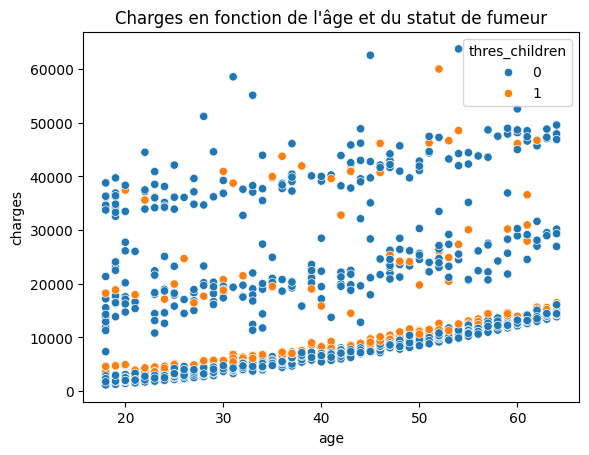

In [89]:
data_processed_bis = data_processed.copy()
data_processed_bis["thres_children"] = data_processed_bis[data_processed["children"] > 2]["const"]
data_processed_bis["thres_children"] = data_processed_bis["thres_children"].fillna(0)
data_processed_bis["thres_children"] = data_processed_bis["thres_children"].astype(int)
data_processed_bis = data_processed_bis.drop("children", axis = 1)

sns.scatterplot(data = data_processed_bis, y = "charges",x = "age",hue="thres_children")
plt.title("Charges en fonction de l'âge et du statut de fumeur")
plt.show()

Avoir beaucoup d'enfant (plus de 2) ne semble donc pas avoir beaucoup de d'influence notable sur les charges. Ils semblent répartis selon la distribution générale.

Ecart-types des coefficients :
const             742.479374
age                17.679514
thres_children    683.428713
dtype: float64


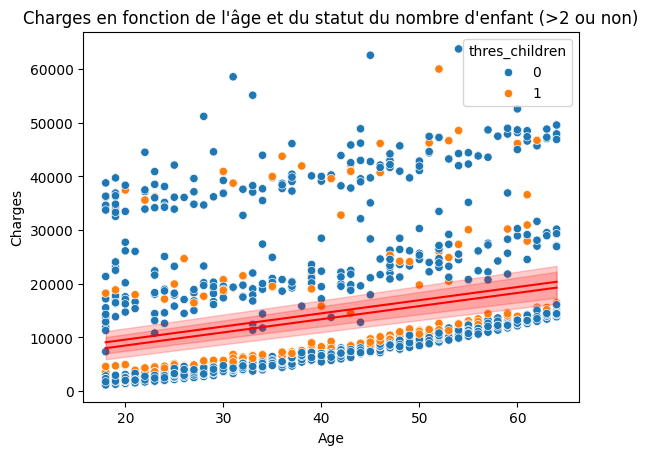

In [ ]:
y = data_processed_bis["charges"]
X = data_processed_bis.drop("charges", axis=1)
X = X[["const","age","thres_children"]]
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)
results = sm.OLS(y_train,X_train).fit()
#Pas de scaler car une seule variable quantitative
print("Ecart-types des coefficients :")
print(results.bse)

age_range = np.linspace(data_processed_bis['age'].min(), data_processed_bis['age'].max(), 200)
charges_pred_bcp_enfant = results.params.iloc[0] + results.params.iloc[1]*age_range + results.params.iloc[2]*1
charges_pred_peu_enfant = results.params.iloc[0] + results.params.iloc[1]*age_range + results.params.iloc[2]*0

se_pred_bcp_enfant = np.sqrt(results.bse.iloc[0]**2 + (age_range*results.bse.iloc[1])**2 + (1*results.bse.iloc[2])**2)
se_pred_peu_enfant = np.sqrt(results.bse.iloc[0]**2 + (age_range*results.bse.iloc[1])**2 + (0*results.bse.iloc[2])**2)

lower_bcp_enfant = charges_pred_bcp_enfant - 1.96*se_pred_bcp_enfant
upper_bcp_enfant = charges_pred_bcp_enfant + 1.96*se_pred_bcp_enfant

lower_peu_enfant = charges_pred_peu_enfant - 1.96*se_pred_bcp_enfant
upper_peu_enfant = charges_pred_peu_enfant + 1.96*se_pred_bcp_enfant

sns.scatterplot(data = data_processed_bis, y = "charges",x = "age",hue="thres_children")
plt.title("Charges en fonction de l'âge et du statut du nombre d'enfant (>2 ou non)")
plt.plot(age_range, charges_pred_bcp_enfant, color='red', label='Droite de régression >2 enfant')
plt.plot(age_range, charges_pred_peu_enfant, color='red', label='Droite de régression <=2 enfant')
plt.fill_between(age_range, lower_bcp_enfant, upper_bcp_enfant, color='red', alpha=0.2, label='IC 95%')
plt.fill_between(age_range, lower_peu_enfant, upper_peu_enfant, color='red', alpha=0.2, label='IC 95%')

plt.xlabel("Age")
plt.ylabel("Charges")
plt.show()

On voit que les deux droites de régression sont très proches, indiquant que le fait d'avoir peu ou beaucoup d'enfant n'est pas différenciant.

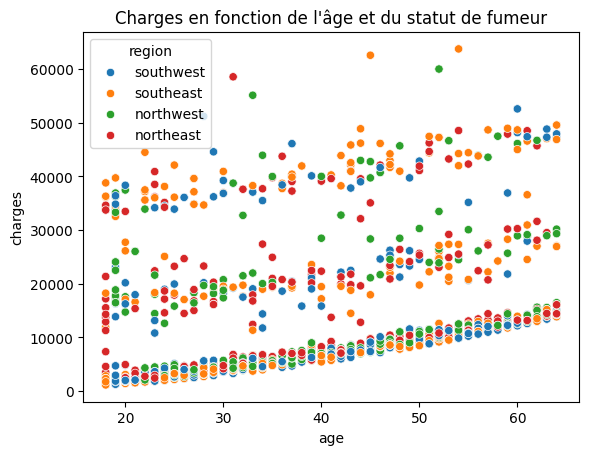

In [ ]:
sns.scatterplot(data = data, y = "charges",x = "age",hue="region")
plt.title("Charges en fonction de l'âge et du statut de fumeur")
plt.show()

Ecart-types des coefficients :
const               587.876335
age                  17.613890
region_southwest    453.611471
region_southeast    434.496682
region_northwest    453.890362
region_northeast    457.976821
dtype: float64


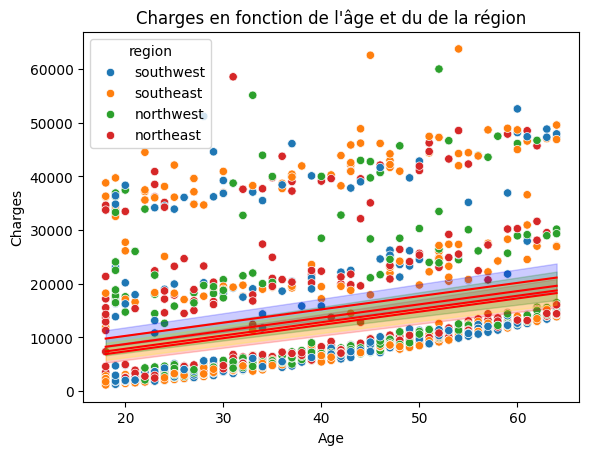

In [104]:
y = data_processed["charges"]
X = data_processed.drop("charges", axis=1)
X = X[["const","age","region_southwest","region_southeast","region_northwest","region_northeast"]]
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)
results = sm.OLS(y_train,X_train).fit()
#Pas de scaler car une seule variable quantitative
print("Ecart-types des coefficients :")
print(results.bse)

age_range = np.linspace(data_processed['age'].min(), data_processed['age'].max(), 200)
charges_pred_SW = results.params.iloc[0] + results.params.iloc[1]*age_range + results.params.iloc[2]*1 + results.params.iloc[3]*0 + results.params.iloc[4]*0 + results.params.iloc[5]*0
charges_pred_SE = results.params.iloc[0] + results.params.iloc[1]*age_range + results.params.iloc[2]*0 + results.params.iloc[3]*1 + results.params.iloc[4]*0 + results.params.iloc[5]*0
charges_pred_NW = results.params.iloc[0] + results.params.iloc[1]*age_range + results.params.iloc[2]*0 + results.params.iloc[3]*0 + results.params.iloc[4]*1 + results.params.iloc[5]*0
charges_pred_NE = results.params.iloc[0] + results.params.iloc[1]*age_range + results.params.iloc[2]*0 + results.params.iloc[3]*0 + results.params.iloc[4]*0 + results.params.iloc[5]*1

se_pred_SW = np.sqrt(results.bse.iloc[0]**2 + (age_range*results.bse.iloc[1])**2 + (1*results.bse.iloc[2])**2+(0*results.bse.iloc[3])**2+(0*results.bse.iloc[4])**2+(0*results.bse.iloc[5])**2)
se_pred_SE = np.sqrt(results.bse.iloc[0]**2 + (age_range*results.bse.iloc[1])**2 + (0*results.bse.iloc[2])**2+(1*results.bse.iloc[3])**2+(0*results.bse.iloc[4])**2+(0*results.bse.iloc[5])**2)
se_pred_NW = np.sqrt(results.bse.iloc[0]**2 + (age_range*results.bse.iloc[1])**2 + (0*results.bse.iloc[2])**2+(0*results.bse.iloc[3])**2+(1*results.bse.iloc[4])**2+(0*results.bse.iloc[5])**2)
se_pred_NE = np.sqrt(results.bse.iloc[0]**2 + (age_range*results.bse.iloc[1])**2 + (0*results.bse.iloc[2])**2+(0*results.bse.iloc[3])**2+(0*results.bse.iloc[4])**2+(1*results.bse.iloc[5])**2)

lower_SW = charges_pred_SW - 1.96*se_pred_SW
upper_SW = charges_pred_SW + 1.96*se_pred_SW

lower_SE = charges_pred_SE - 1.96*se_pred_SE
upper_SE = charges_pred_SE + 1.96*se_pred_SE

lower_NW = charges_pred_NW - 1.96*se_pred_NW
upper_NW = charges_pred_NW + 1.96*se_pred_NW

lower_NE = charges_pred_NE - 1.96*se_pred_NE
upper_NE = charges_pred_NE + 1.96*se_pred_NE

sns.scatterplot(data = data, y = "charges",x = "age",hue="region")
plt.title("Charges en fonction de l'âge et du de la région")
plt.plot(age_range, charges_pred_SW, color='red', label='Droite de régression SouthWest')
plt.plot(age_range, charges_pred_SE, color='red', label='Droite de régression SouthEast')
plt.plot(age_range, charges_pred_NW, color='red', label='Droite de régression NorthWest')
plt.plot(age_range, charges_pred_NE, color='red', label='Droite de régression NorthEast')

plt.fill_between(age_range, lower_SW, upper_SW, color='red', alpha=0.2, label='IC 95%')
plt.fill_between(age_range, lower_SE, upper_SE, color='blue', alpha=0.2, label='IC 95%')
plt.fill_between(age_range, lower_NW, upper_NW, color='yellow', alpha=0.2, label='IC 95%')
plt.fill_between(age_range, lower_NE, upper_NE, color='green', alpha=0.2, label='IC 95%')


plt.xlabel("Age")
plt.ylabel("Charges")
plt.show()

De même pour la région, ce coefficient ne semble pas influence la répartition :les droites de régression sont très proches, indiquant que le fait d'être de telle ou telle n'est pas différenciant dans les charges.

In [51]:
##Stepwise model selection : backward
y = data_processed["charges"]
col = data_processed.columns
col = col.drop("charges")
list_col = col

for var in col:
    
    print("\nVariables used :")
    if(len(list_col.to_list())>0):
        print(list_col.to_list())
        X = data_processed[list_col]

        X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

        results = sm.OLS(y_train,X_train).fit()
        print(results.summary())

        list_col = list_col.drop(var) 
    else:
        print("Backward ended")


Variables used :
['const', 'age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     844.2
Date:                Mon, 01 Dec 2025   Prob (F-statistic):               0.00
Time:                        09:50:33   Log-Likelihood:                -22432.
No. Observations:                2217   AIC:                         4.488e+04
Df Residuals:                    2208   BIC:                         4.493e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t 

Ainsi, comment nous avons pu le voir dans forward model selection (et aussi le backward juste au-dessus) et tout au long de l'analyse des multiples régressions, le modèle semblant le plus adéquat est celui comprenant comme variable explicatives des charges médicales l'âge, le BMI (IMC en français) et le fait d'être fumeur ou non. Nous allons donc maintenant entraîner ce modèle et vérifier les hypothèses sur les résidus.

In [124]:
y = data_processed["charges"]
X = data_processed.drop("charges", axis=1)
X = X[["const","bmi","age","smoker_yes"]]

X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

age_mean = X_train["age"].mean()
age_std = X_train["age"].std()
bmi_mean = X_train["bmi"].mean()
bmi_std = X_train["bmi"].std()

X_train_std = X_train.copy()
X_train_std["age"] = (X_train["age"]-age_mean)/age_std
X_train_std["bmi"] = (X_train["bmi"]-bmi_mean)/bmi_std

X_test_std = X_test.copy()
X_test_std["age"] = (X_test["age"]-age_mean)/age_std
X_test_std["bmi"] = (X_test["bmi"]-bmi_mean)/bmi_std

results = sm.OLS(y_train,X_train_std).fit()

#Résultats et analyses
print(results.summary())

p = len(X_test.columns)-1 #On ne compte pas la colonne constante
n = len(y_test)

print()

y_pred = results.predict(X_test_std)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(n-1)/(n-p-1) 

print("RMSE :", rmse)
print("R2 :", r2)
print("Adjusted R² :", adj_r2)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     2214.
Date:                Mon, 01 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:55:04   Log-Likelihood:                -22448.
No. Observations:                2217   AIC:                         4.490e+04
Df Residuals:                    2213   BIC:                         4.493e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8376.4741    144.457     57.986      0.0

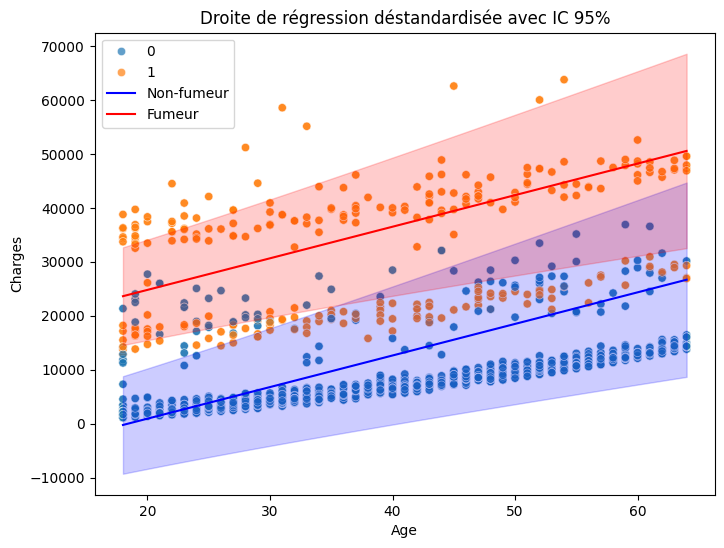

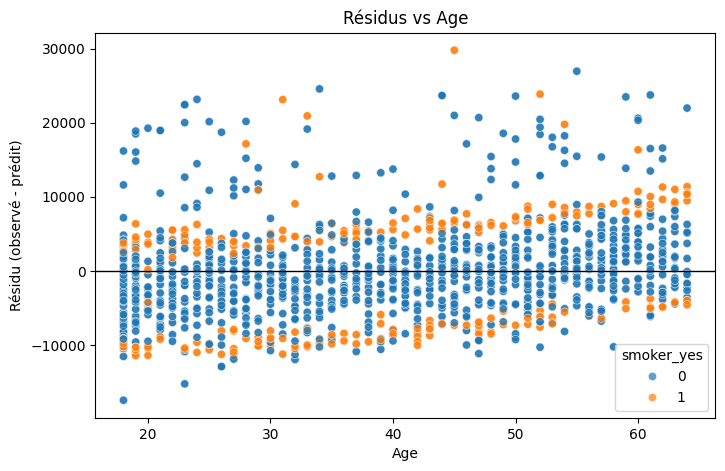

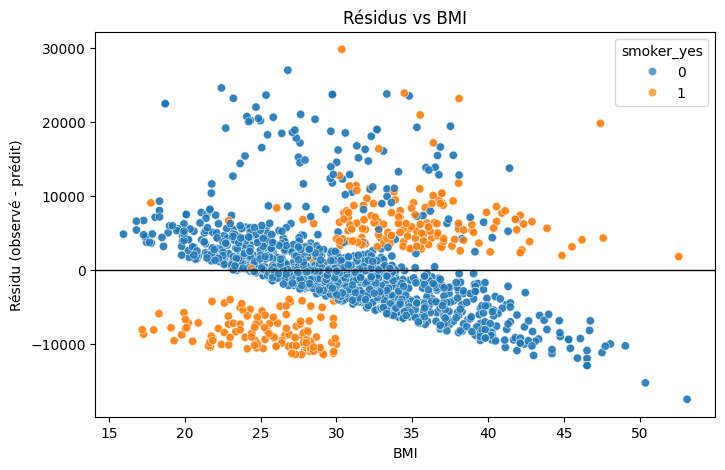

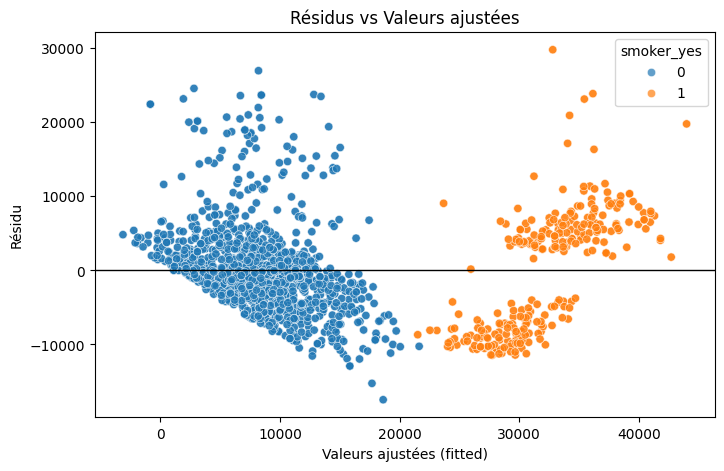

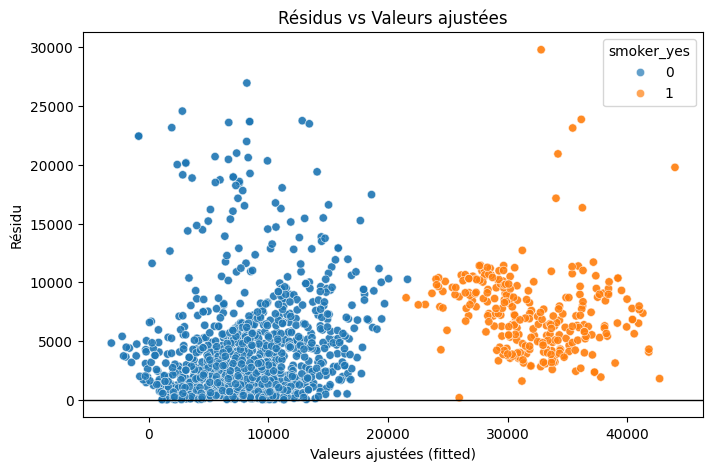

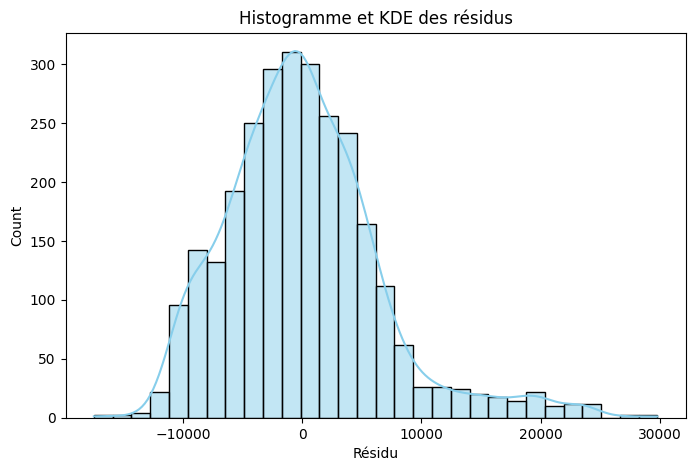

<Figure size 600x600 with 0 Axes>

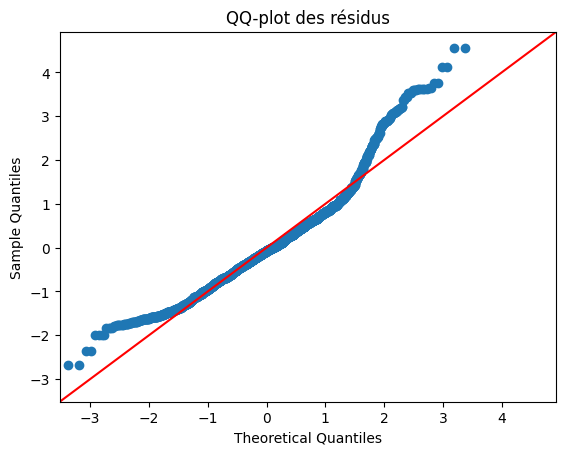

In [135]:
def destandardize_statsmodels(model, means, stds, feature_names):
    beta = model.params.copy()
    V = model.cov_params().copy()
    p = len(beta)
    A = np.eye(p)

    for i, feat in enumerate(feature_names, start=1):
        A[i, i] = 1.0 / stds[feat]
        A[0, i] = - means[feat] / stds[feat]
    
    beta_unstd = A @ beta.values
    V_unstd = A @ V.values @ A.T
    se_unstd = np.sqrt(np.diag(V_unstd))
    out = pd.DataFrame({"coef_unstd": beta_unstd,"se_unstd": se_unstd}, index=beta.index)

    # IC 95%
    out['IC_lower'] = out['coef_unstd'] - 1.96*out['se_unstd']
    out['IC_upper'] = out['coef_unstd'] + 1.96*out['se_unstd']
    return out

model = results

#Graphique de régression 

means = {"age_std": age_mean, "bmi_std": bmi_mean}
stds  = {"age_std": age_std,  "bmi_std": bmi_std}

results_unstd = destandardize_statsmodels(model, means, stds, feature_names=['age_std','bmi_std'])
coefs = results_unstd['coef_unstd']

def predict_with_IC(age_vals, smoker_val):
    y_hat = coefs['const'] + coefs['age']*age_vals + coefs['bmi']*bmi_mean + coefs['smoker_yes']*smoker_val
    
    # Variance prédiction = X @ Cov @ X^T
    X_mat = np.vstack([np.ones_like(age_vals), age_vals, np.repeat(bmi_mean,len(age_vals)), np.repeat(smoker_val,len(age_vals))]).T
    V = model.cov_params().values

    # Déstandardiser X_mat pour utiliser cov_params non standardisée
    # Ici on approxime en utilisant coefficients déstandardisées
    # IC = y_hat ± 1.96 * SE prédiction
    se_hat = np.sqrt(np.sum((X_mat * X_mat) * np.diag(V), axis=1)) # approximation
    lower = y_hat - 1.96*se_hat
    upper = y_hat + 1.96*se_hat
    return y_hat, lower, upper

y_ns, lower_ns, upper_ns = predict_with_IC(age_range, 0)
y_s, lower_s, upper_s = predict_with_IC(age_range, 1)

plt.figure(figsize=(8,6))
sns.scatterplot(x='age', y='charges', hue='smoker_yes', data=data_processed, palette='tab10', alpha=0.7)

plt.plot(age_range, y_ns, color='blue', label='Non-fumeur')
plt.fill_between(age_range, lower_ns, upper_ns, color='blue', alpha=0.2)

plt.plot(age_range, y_s, color='red', label='Fumeur')
plt.fill_between(age_range, lower_s, upper_s, color='red', alpha=0.2)

plt.xlabel('Age')
plt.ylabel('Charges')
plt.title('Droite de régression déstandardisée avec IC 95%')
plt.legend()
plt.show()

X_std = pd.concat([X_train_std,X_test_std], axis = 0)

X_scaled = X_std[['age','bmi','smoker_yes']]
X_scaled = sm.add_constant(X_scaled)
y_pred_all = model.predict(X_scaled)
residuals = data_processed['charges'] - y_pred_all

#Résidus vs Age

plt.figure(figsize=(8,5))
sns.scatterplot(x=data_processed['age'], y=residuals, hue=data_processed['smoker_yes'], palette='tab10', alpha=0.7)
plt.axhline(0, color='black', linewidth=1)
plt.xlabel('Age')
plt.ylabel('Résidu (observé - prédit)')
plt.title('Résidus vs Age')
plt.legend(title='smoker_yes')
plt.show()

#Résidus vs BMI

plt.figure(figsize=(8,5))
sns.scatterplot(x=data_processed['bmi'], y=residuals, hue=data_processed['smoker_yes'], palette='tab10', alpha=0.7)
plt.axhline(0, color='black', linewidth=1)
plt.xlabel('BMI')
plt.ylabel('Résidu (observé - prédit)')
plt.title('Résidus vs BMI')
plt.legend(title='smoker_yes')
plt.show()

#Résidus vs fitted values

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_all, y=residuals, hue=data_processed['smoker_yes'], palette='tab10', alpha=0.7)
plt.axhline(0, color='black', linewidth=1)
plt.xlabel('Valeurs ajustées (fitted)')
plt.ylabel('Résidu')
plt.title('Résidus vs Valeurs ajustées')
plt.legend(title='smoker_yes')
plt.show()

#Résidus vs abs(fitted values)

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_all, y=np.abs(residuals), hue=data_processed['smoker_yes'], palette='tab10', alpha=0.7)
plt.axhline(0, color='black', linewidth=1)
plt.xlabel('Valeurs ajustées (fitted)')
plt.ylabel('Résidu')
plt.title('Résidus vs Valeurs ajustées')
plt.legend(title='smoker_yes')
plt.show()

#Histogramme + KDE

plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, bins=30, color='skyblue')
plt.xlabel('Résidu')
plt.title('Histogramme et KDE des résidus')
plt.show()

#QQ-plot

plt.figure(figsize=(6,6))
sm.qqplot(residuals, line='45', fit=True)
plt.title('QQ-plot des résidus')
plt.show()

D'après ces graphiques : 
- Le QQ-plot des résidus semble indiquer une appromimative normalité pour les quantiles centraux mais une normalité des résidus bien plus faibles pour les quantiles extrêmes. 
- L'histogramme semble indiquer que les résidus sont certes à peu près centrés en 0 mais que la queue de distribution à droite est bien plus élevée que pour une loi normale. Là aussi cela semble indiquer leur non normalité.\
Nous allons vérifier cela ensuite par les tests de Shapiro-Wilk et de Kolmogorov-Smirnov.
- Les graphes des résidus vs valeurs ajustées (ou celui de leur valeur absolue) montre une structure en croissante et non pas une bande large indiquant que leur variance n'est pas contanste, ils semble hétéroscédastique.\
Nous vérifierons cela avec le test de Breuch-Pagan.
- Enfin, le graphe résidus vs age indique qu'il y a bien une relation linéaire et que les résidus semblent indépendant. Cependant, le graphe résidus vs BMI est bien moins clair semblant indiquer un manque de relation linéaire. Cela est cohérent avec ce que nous avions vu plus haut ou il y avait une certaine relation entre BMI et charges dans le cas des fumeurs mais pas pour les non fumeurs.

In [139]:
#Test de Shapiro-Wilk

shapiro_stat, shapiro_p = stats.shapiro(residuals)
print("Test de Shapiro-Wilk : stat = %.4f, p =%.4f" % (shapiro_stat, shapiro_p))

#Test de Kolmogorov-Smirnov contre N(0, std(residuals))

ks_stat, ks_p = stats.kstest(residuals, 'norm', args=(residuals.mean(), residuals.std()))
print("Test de Kolmogorov-Smirnov : stat = %.4f, p = %.4f" % (ks_stat, ks_p))

#Test de Breusch-Pagan

bp_test = sms.het_breuschpagan(residuals, X)
bp_stat = bp_test[0]
bp_p = bp_test[1]
print("Test de Breusch-Pagan : stat= %.4f, p= %.4f" % (bp_stat, bp_p))

Test de Shapiro-Wilk : stat = 0.9498, p =0.0000
Test de Kolmogorov-Smirnov : stat = 0.0593, p = 0.0000
Test de Breusch-Pagan : stat= 60.6264, p= 0.0000


En effet, tous ces tests on une p-valeur inférieure à 0.05 indiquant que l'on rejette à tous leur hypothèse nulle.\
Ainsi, pour les tests de Shapiro-Wilk et Kolmogorov-Smirnov, nous pouvons rejeter l'hypothèse que les résidus suivent une loi normale à au moins ce niveau de confiance. \
Et, pour le test de Breusch-Pagan, nous pouvons rejeter l'hypothèse que les résidus sont homoscédastiques à au moins ce niveau de confiance. \
Nous allons donc plutôt utilisé un GLM Gamma pour modéliser ce dataset.

## Modèle Gamma

Nous voulons prédire des données positives et continues, la régression linéaire ne semblent pas adaptées, nous allons donc essayer un modèle Gamma.

In [149]:
y = data_processed["charges"]
X = data_processed.drop("charges", axis=1)

model_gamma = sm.GLM(
    y,
    X,
    family=sm.families.Gamma(link=sm.families.links.Log())
).fit()

print(model_gamma.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                charges   No. Observations:                 2772
Model:                            GLM   Df Residuals:                     2763
Model Family:                   Gamma   Df Model:                            8
Link Function:                    Log   Scale:                         0.47975
Method:                          IRLS   Log-Likelihood:                -27594.
Date:                Mon, 01 Dec 2025   Deviance:                       715.28
Time:                        20:13:45   Pearson chi2:                 1.33e+03
No. Iterations:                    19   Pseudo R-squ. (CS):             0.6749
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.8637      0.062  

On voit que le sexe n'est pas non plus significatif dans ce modèle. 

In [151]:
y = data_processed["charges"]
X = data_processed.drop(["charges","sex_male"], axis=1)

model_gamma = sm.GLM(
    y,
    X,
    family=sm.families.Gamma(link=sm.families.links.Log())
).fit()

print(model_gamma.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                charges   No. Observations:                 2772
Model:                            GLM   Df Residuals:                     2764
Model Family:                   Gamma   Df Model:                            7
Link Function:                    Log   Scale:                         0.47819
Method:                          IRLS   Log-Likelihood:                -27593.
Date:                Mon, 01 Dec 2025   Deviance:                       717.27
Time:                        20:14:15   Pearson chi2:                 1.32e+03
No. Iterations:                    18   Pseudo R-squ. (CS):             0.6756
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.8478      0.061  

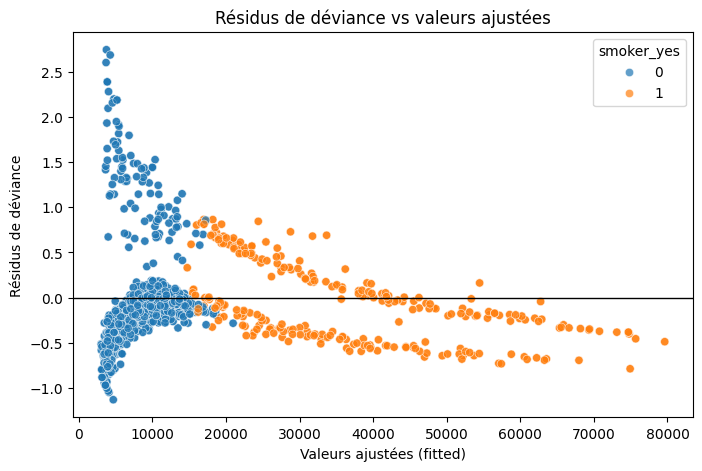

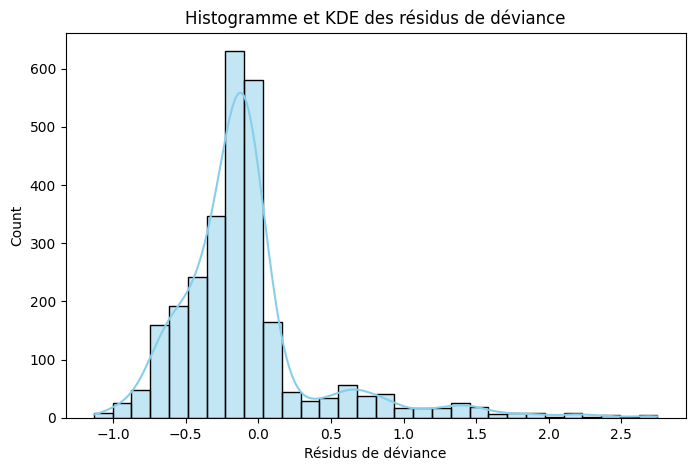

<Figure size 600x600 with 0 Axes>

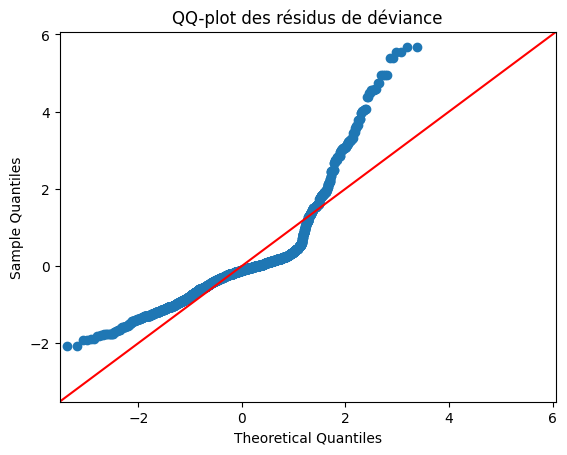

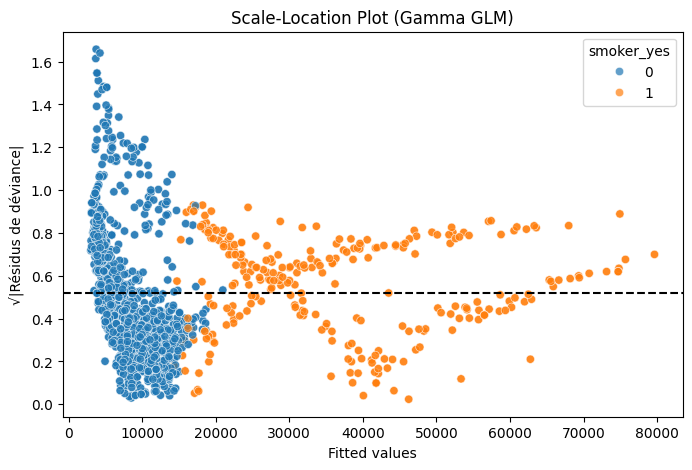

In [152]:
#Résidus et valeurs ajustées
fitted = model_gamma.fittedvalues
resid_dev = model_gamma.resid_deviance # résidus de déviance
resid_pearson = model_gamma.resid_pearson # résidus de Pearson

plt.figure(figsize=(8,5))
sns.scatterplot(x=fitted, y=resid_dev, hue=data_processed['smoker_yes'], palette='tab10', alpha=0.7)
plt.axhline(0, color='black', linewidth=1)
plt.xlabel('Valeurs ajustées (fitted)')
plt.ylabel('Résidus de déviance')
plt.title('Résidus de déviance vs valeurs ajustées')
plt.legend(title='smoker_yes')
plt.show()

#Histogramme et KDE de la déviance
plt.figure(figsize=(8,5))
sns.histplot(resid_dev, kde=True, bins=30, color='skyblue')
plt.xlabel('Résidus de déviance')
plt.title('Histogramme et KDE des résidus de déviance')
plt.show()

#QQ-Plot des résidus de déviance
plt.figure(figsize=(6,6))
sm.qqplot(resid_dev, line='45', fit=True)
plt.title('QQ-plot des résidus de déviance')
plt.show()

#Vérification de l'hétéroscédasticité
plt.figure(figsize=(8,5))
sns.scatterplot(x=fitted, y=np.sqrt(np.abs(resid_dev)), hue=data_processed['smoker_yes'], palette='tab10', alpha=0.7)
plt.xlabel('Fitted values')
plt.ylabel('√|Résidus de déviance|')
plt.title('Scale-Location Plot (Gamma GLM)')
plt.axhline(np.mean(np.sqrt(np.abs(resid_dev))), color='black', linestyle='--')
plt.show()

Pour les résidus de déviance, ils n'augmentent pas avec les prédictions ce qui montre cette fois une certaine homoscédasticité mais il y a un motif clair montrant donc que ce n'est pas une relation log-linéaire.\
L'homoscédasticité s'observe dans le dernier graphe : on est plutôt sur des données hétéroscédastique car les résidus ne sont pas sur une ligne mais ont une tendance globale.\
Pour l'histogramme des résidus, on voit qu'ils sont globalement centrés autour de zéro, mais il y a tout de même une asymétrie vers la droite suggérant peut-être un couplage avec un modèle de Pareto.\
Cela se retrouve dans le QQ-Plot où ses extrémités sont loins de la diagonale. Les résidus ne suivent donc pas une loi normale, ce qui est cohérent.\
\
Afin de mieux traiter les outliers, nous allons rapidement implémenter une loi de Pareto qui leur sera dédiée, un modèle Gamma s'occupera du reste des données.


In [ ]:
seuil = np.percentile(data_processed['charges'], 95)
df_gamma = data_processed[data_processed['charges'] <= seuil]
df_pareto = data_processed[data_processed['charges'] > seuil]

X_gamma = df_gamma.drop(["charges","sex_male"],axis=1)
y_gamma = df_gamma["charges"]

#Modèle Gamma
model_gamma = sm.GLM(y_gamma,X_gamma,family=sm.families.Gamma(link=sm.families.links.Log())).fit()
resid_dev = model_gamma.resid_deviance
fitted = model_gamma.fittedvalues

#Loi de Pareto
x_m = seuil
params = pareto.fit(df_pareto['charges'], floc=x_m)  
alpha = params[0]
print("Paramètre alpha Pareto :", alpha)

Paramètre alpha Pareto : 0.18699991467044108


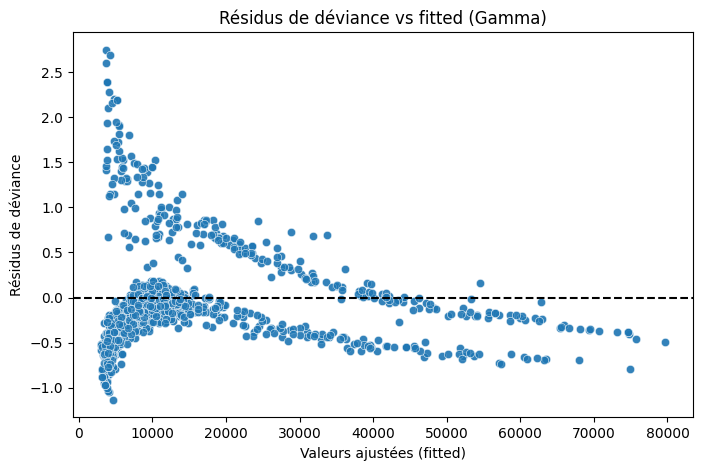

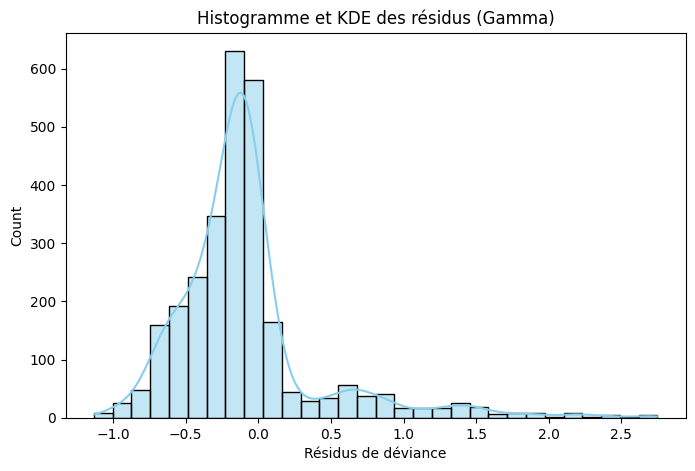

<Figure size 600x600 with 0 Axes>

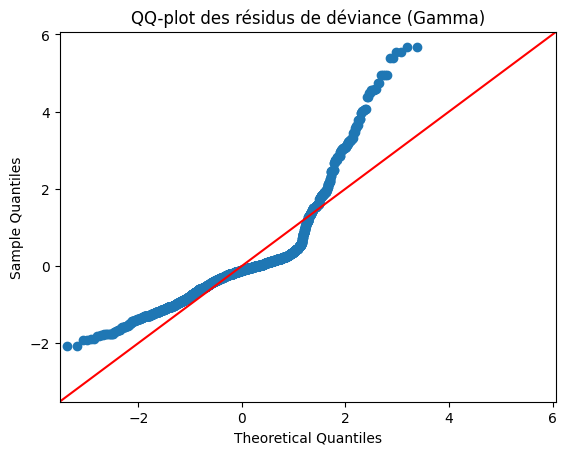

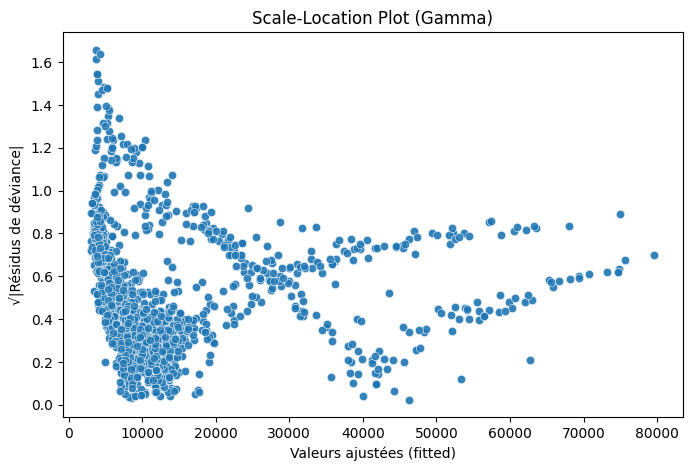

Shapiro-Wilk (Gamma resid_dev): stat=0.8134, p=0.0000
KS test (Gamma resid_dev): stat=0.2100, p=0.0000


TypeError: 'numpy.ndarray' object is not callable

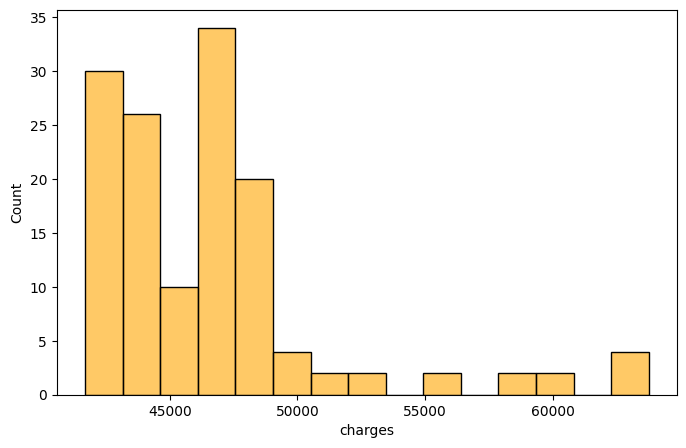

In [ ]:
##Visualisation GLM Gamma

#Résidus de déviance vs valeurs ajustées

plt.figure(figsize=(8,5))
sns.scatterplot(x=fitted, y=resid_dev, alpha=0.7)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Valeurs ajustées (fitted)")
plt.ylabel("Résidus de déviance")
plt.title("Résidus de déviance vs fitted (Gamma)")
plt.show()

#Histogramme + KDE des résidus

plt.figure(figsize=(8,5))
sns.histplot(resid_dev, kde=True, bins=30, color='skyblue')
plt.xlabel("Résidus de déviance")
plt.title("Histogramme et KDE des résidus (Gamma)")
plt.show()

#QQ-plot

plt.figure(figsize=(6,6))
sm.qqplot(resid_dev, line='45', fit=True)
plt.title("QQ-plot des résidus de déviance (Gamma)")
plt.show()

#Scale-Location plot (√|resid_dev| vs fitted)

plt.figure(figsize=(8,5))
sns.scatterplot(x=fitted, y=np.sqrt(np.abs(resid_dev)), alpha=0.7)
plt.xlabel("Valeurs ajustées (fitted)")
plt.ylabel("√|Résidus de déviance|")
plt.title("Scale-Location Plot (Gamma)")
plt.show()


from scipy.stats import pareto, shapiro, kstest

##Tests statistiques GLM Gamma

#Shapiro-Wilk sur résidus de déviance

shapiro_stat, shapiro_p = shapiro(resid_dev)
print("Shapiro-Wilk (Gamma resid_dev): stat=%.4f, p=%.4f" % (shapiro_stat, shapiro_p))

#Kolmogorov-Smirnov contre N(0, std)

ks_stat, ks_p = kstest(resid_dev, 'norm', args=(resid_dev.mean(), resid_dev.std()))
print("KS test (Gamma resid_dev): stat=%.4f, p=%.4f" % (ks_stat, ks_p))

#Visualisation Pareto
plt.figure(figsize=(8,5))
sns.histplot(df_pareto['charges'], bins=15, color='orange', alpha=0.6, label='Outliers')
x_vals = np.linspace(x_m, df_pareto['charges'].max(), 100)
plt.plot(x_vals, len(df_pareto)(pareto.pdf(x_vals, alpha, loc=x_m)(x_vals[1]-x_vals[0])),
color='red', lw=2, label='PDF Pareto')
plt.xlabel("Charges")
plt.ylabel("Effectif / densité")
plt.title("Histogramme des outliers et densité Pareto")
plt.legend()
plt.show()

#QQ-plot log-log Pareto (vérification queue lourde)

plt.figure(figsize=(6,6))
log_sorted = np.log(np.sort(df_pareto['charges']))
log_empirical_cdf = -np.log(1 - np.arange(1,len(df_pareto)+1)/len(df_pareto))
plt.scatter(log_sorted, log_empirical_cdf, alpha=0.7)
plt.plot(log_sorted, alpha*np.log(log_sorted - x_m), color='red', label='Référence Pareto')
plt.xlabel("log(Charges)")
plt.ylabel("-log(1-CDF empirique)")
plt.title("QQ-plot log-log Pareto (outliers)")
plt.legend()
plt.show()

A finir (visualisation + interprétation)

## Modèle linéaire avec données log

Revoir

Text(0.5, 1.0, 'Distribution de log(charges)')

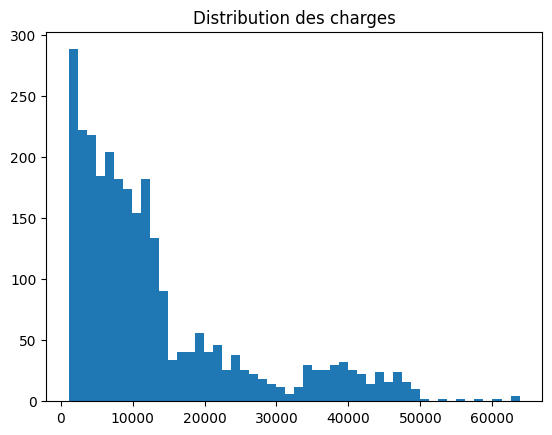

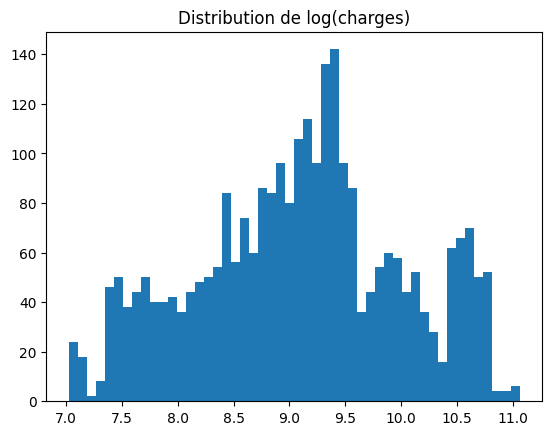

In [53]:
df["log_charges"] = np.log(df["charges"])

plt.figure()
plt.hist(df["charges"], bins=50)
plt.title("Distribution des charges")

plt.figure()
plt.hist(df["log_charges"], bins=50)
plt.title("Distribution de log(charges)")


On observe qu'il serait peut etre utile de faire une observation de log charges plutot que charges, et de retrouver les valeurs plus tard.

<Axes: xlabel='bmi_cat', ylabel='charges'>

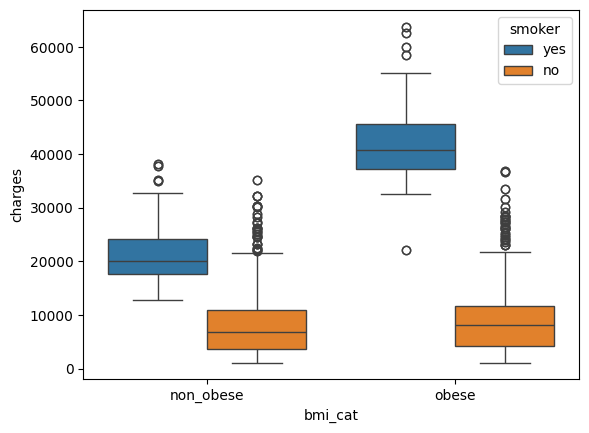

In [54]:
df["bmi_cat"] = np.where(df["bmi"] >= 30, "obese", "non_obese")

sns.boxplot(data=df, x="bmi_cat", y="charges", hue="smoker")

Les boxplots corroborent l'information que l'effet "obesité" est beaucoup plus fort chez les fumeurs que chez les non fumeurs.
Precisement, on observe quasi aucune différence entre les non fumeurs non obeses et les non fumeurs obeses
En revanche, le fait de fumer change grandement les charges, comme observé, et cet effet est accru par l'obesité.

In [55]:



df["log_charges"] = np.log(df["charges"])

formula = "log_charges ~ age + smoker + bmi_cat + smoker:bmi_cat + children + sex + region"

glm_log = smf.glm(formula=formula,
                  data=df,
                  family=sm.families.Gaussian()).fit()

print(glm_log.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:            log_charges   No. Observations:                 2772
Model:                            GLM   Df Residuals:                     2762
Model Family:                Gaussian   Df Model:                            9
Link Function:               Identity   Scale:                         0.18315
Method:                          IRLS   Log-Likelihood:                -1575.6
Date:                Mon, 01 Dec 2025   Deviance:                       505.86
Time:                        09:50:34   Pearson chi2:                     506.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9744
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Une regression lineaire sur le log charges offre deja 0.975 de R²

Il y plusieurs informations importantes:
pour un fumeur non obese, il y a exp(1.21)=3.4 fois plus de charges qu'un non fumeur non obese
pour un obese non fumeur, il y a exp(0.2)=1.23 fois plus de charges qu'un non fumeur non obese

De surcroit, il y a un coefficient exp(0.65)=1.91 fois plus de charges en plus lorsque l'on est fumeur et obese.

# Modèle XGBoost

In [57]:
databoost = data_processed.copy()
databoost["log_charges"] = np.log(databoost["charges"])
databoost.drop(["charges","const"],axis = 1, inplace=True)
databoost.head()

,age,bmi,children,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,log_charges
0,19,27.900,0,0,1,0,0,0,1,9.734176
1,18,33.770,1,1,0,0,0,1,0,7.453302
2,28,33.000,3,1,0,0,0,1,0,8.400538
3,33,22.705,0,1,0,0,1,0,0,9.998092
4,32,28.880,0,1,0,0,1,0,0,8.260197


In [58]:
# databoost = data.copy()
# databoost["sex_male"] = (databoost["sex"] == "male").astype(int)
# databoost["smoker_yes"] = (databoost["smoker"] == "yes").astype(int)
# databoost["log_charges"] = np.log(databoost["charges"])
# databoost = databoost.drop(columns=["sex", "smoker", "charges"])
# region_dummies = pd.get_dummies(databoost["region"], prefix="region").astype(int)
# databoost = pd.concat(
#     [databoost.drop(columns=["region"]), region_dummies],
#     axis=1
# )
# databoost.head()

On a prépare le jeu de données databoost de sorte à ne plus avoir de valeurs non numériques et d'avoir les charges médicale en échelle logarithmiques. \
On lance un modèle de machine learning non-GLM que nous avons pu étudier : XGBoost. Cet algorithme est très performant peu importe la tâche confiée. 


In [59]:
features = [c for c in databoost.columns if c != "log_charges"]
X = databoost[features]
y = databoost["log_charges"]

X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

model_xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=0,
    n_jobs=-1
)

model_xgb.fit(X_train, y_train)

y_pred_log = model_xgb.predict(X_test)
rmse_log = root_mean_squared_error(y_test, y_pred_log)
r2_log = r2_score(y_test, y_pred_log)
adj_r2_log = 1-(1-r2_log)*(len(y_test)-1)/(len(y_test)-10-1) #On a 10 variables explicatives

print("RMSE (log_charges):", rmse_log)
print("R² (log_charges):", r2_log)
print("Adjusted R² (log_charges) :", adj_r2_log)

RMSE (log_charges): 0.35931716418016957
R² (log_charges): 0.8626382301184636
Adjusted R² (log_charges) : 0.8601131975838766


Les résultats sont déjà très bons, on ajoute aussi le concept de "K-Fold Cross Validation", cela permet de limiter un peu le biais par rapport à la répartition du dataset Train.

In [60]:
features = [c for c in databoost.columns if c != "log_charges"]
X = databoost[features]
y = databoost["log_charges"]

#X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42) #Pas nécessaire car on utilise un K-Fold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

model_xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=0,
    n_jobs=-1
)

scoring = {
    "rmse": "neg_root_mean_squared_error",
    "r2": "r2"
}

cv_results = cross_validate(
    model_xgb,
    X,
    y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

rmse_folds = -cv_results["test_rmse"]
r2_folds = cv_results["test_r2"]
adj_r2_log = 1-(1-r2_folds.mean())*(len(y_test)-1)/(len(y_test)-10-1) #On a 10 variables

print("XGB RMSE moyen (log_charges):", rmse_folds.mean())
print("XGB RMSE par fold:", rmse_folds)
print("XGB R2 moyen (log_charges):", r2_folds.mean())
print("XGB R2 par fold:", r2_folds)


XGB RMSE moyen (log_charges): 0.3233514347800817
XGB RMSE par fold: [0.36077071 0.32938134 0.28625902 0.31284301 0.3275031 ]
XGB R2 moyen (log_charges): 0.8771808714555848
XGB R2 par fold: [0.86152464 0.87225249 0.89578128 0.88647316 0.86987279]


Un peu moins bon, ce n'est pas choquant, car l'information est plutot excellente de base, et il y a peu d'outlier, mais plutôt une ligne directive claire, tracée par les categories fumeurs et la colonne BMI.\
On perd alors de la précision à vouloir chercher des comportements sur des petits segments, lorsqu'il y a un comportement très visible dans l'ensemble, sans "imbalance" comme on peut voir en classification. \
On teste maintenant sur charges et non log charges.

In [61]:
databoost_no_log = data_processed.copy()
databoost_no_log.drop(["const"],axis = 1, inplace=True)
databoost_no_log.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,0,1
1,18,33.770,1,1725.55230,1,0,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,0,1,0
3,33,22.705,0,21984.47061,1,0,0,1,0,0
4,32,28.880,0,3866.85520,1,0,0,1,0,0


In [62]:
features = [c for c in databoost_no_log.columns if c != "log_charges"]
X = databoost_no_log[features]
y = databoost_no_log["charges"]

X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42) 


model_xgb_nolog = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=0,
    n_jobs=-1
)
model_xgb_nolog.fit(X_train, y_train)
y_pred = model_xgb_nolog.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(len(y_test)-1)/(len(y_test)-9-1) #On a 9 variables explicatives

print("RMSE (charges):", rmse)
print("R2 (charges):", r2)
print("Adjusted R² (charges) :", adj_r2)

RMSE (charges): 429.7128972841638
R2 (charges): 0.9987968984720331
Adjusted R² (charges) : 0.9987770307403786


Legerement mieux, (revoir)

XGBoost : on perd complètement l'interprétabilité des résultats